# Part 1

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from scipy.stats import norm
import matplotlib.pyplot as plt

## 2.

In [3]:
# read data
amzn1 = pd.read_pickle("./amzn1.pkl")
amzn2 = pd.read_pickle("./amzn2.pkl")

spy1 = pd.read_pickle("./spy1.pkl")
spy2 = pd.read_pickle("./spy2.pkl")

vix1 = pd.read_pickle("./vix1.pkl")
vix2 = pd.read_pickle("./vix2.pkl")


# discard useless data
def clean_data(ticker, data):
    del data[0]
    del data[0]
    temp = yf.Ticker(ticker)
    expiry = pd.Series(temp.options)
    expiry = pd.to_datetime(expiry)
    expiry = expiry - pd.Timestamp('today') < pd.Timedelta('80d')
    kept = len(expiry[expiry].index.values)
    newdata = data[0:kept]
    # add new columns of option type and expiry date
    def findType(s):
        if 'C' in s.replace(ticker, ''):
            return 'c'
        else:
            return 'p'
    def findDate(s):
        if 'VIXW' in s:
            return '20'+ s.replace('VIXW', '')[0:6]
        elif 'VIX' in s:
            return '20' + s.replace('VIX', '')[0:6]
        else:
            return '20' + s.replace(ticker, '')[0:6]
    for df in newdata:
        df['type'] = df['contractSymbol'].map(findType)
        df['expiry'] = df['contractSymbol'].map(findDate)
        df['expiry'] = pd.to_datetime(df['expiry'], infer_datetime_format=True)
        df['delta_t'] = (df['expiry'] - pd.Timestamp('today')) / np.timedelta64(1, 'Y')
    return newdata


amzn1 = clean_data("AMZN", amzn1)
amzn2 = clean_data("AMZN", amzn2)

spy1 = clean_data("SPY", spy1)
spy2 = clean_data("SPY", spy2)

vix1 = clean_data("^VIX", vix1)
vix2 = clean_data("^VIX", vix2)

DATA1 = [amzn1, spy1, vix1]
DATA2 = [amzn2, spy2, vix2]

In [4]:
def bisection(f, a, b):
    while abs(a - b) >= 1e-6:
        c = (a + b) / 2
        if f(c) == 0:
            break
        if f(a) * f(c) < 0:
            b = c
        else:
            a = c
    return c


def BS_formula(Type, S, K, T, sigma, r):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if Type == 'c':
        return norm.cdf(d1) * S - norm.cdf(d2) * K * np.exp(-r * T)
    elif Type == 'p':
        return K * np.exp(-r * T) * norm.cdf(-d2) - norm.cdf(-d1) * S
    else:
        raise TypeError("Type must be 'c' for call, 'p' for put")

        
def vega(S, K, T, sigma, r):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return np.sqrt(T)*S*norm.pdf(d1)
    
    
def newton_method(f, f_prime, x0, tol=1e-6, N=100):
    for i in range(N):
        x1 = x0 - f(x0)/f_prime(x0)
        if abs(x1- x0) < tol:
            break
        x0 = x1
    return x1


def get_impliedVol(Type, S, K, T, r, P, method):
    def price_diff(sigma):
        return BS_formula(Type, S, K, T, sigma, r) - P
    if method == 'b':
        return bisection(price_diff, 0.001, 1)
    elif method == 'n':
        price_diff_prime = lambda x: vega(S, K, T, x, r)
        return newton_method(price_diff, price_diff_prime, 0.5)

In [5]:
for i in range(3):
    for df in DATA1[i]:
        df['optionPrice'] = df['bid']/2 + df['ask']/2

In [6]:
r = 0.07/100
now = pd.Timestamp.now()
for i in range(2):
    for df in DATA1[i]:
        df['bisec_Root'] = df.apply(lambda x: get_impliedVol(x.type, x.spotPrice, x.strike,
                                                             x.delta_t, r, x.optionPrice, 'b'), axis=1)
end = pd.Timestamp.now()
bisec_time = (end - now) / np.timedelta64(1, 's')
print("It takes {} seconds".format(bisec_time))

<ipython-input-4-f49d1676a7fe>:14: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
<ipython-input-4-f49d1676a7fe>:15: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)


It takes 45.809111 seconds


In [7]:
#         df['newton_Root'] = df.apply(lambda x: get_impliedVol(x.type, x.spotPrice, x.strike,
#                                                              x.delta_t, r, x.optionPrice, 'n'), axis=1)

In [8]:
def moneyness(S, K):
    if S/K < 0.95:
        return 'inTheMoney'
    elif S/K > 1.05:
        return 'outTheMoney'
    else:
        return 'atTheMoney'
for i in range(3):
    for df in DATA1[i]:
        df['moneyness'] = df.apply(lambda x: moneyness(x.spotPrice, x.strike), axis=1)

In [9]:
temp = DATA1[1][7]
# temp[temp['moneyness'] == 'atTheMoney'][info]

In [11]:
temp['expiry'].iloc[0]

Timestamp('2021-03-19 00:00:00')

In [12]:
expiry_date = []
in_mean = []
out_mean = []
at_mean = []
for df in DATA1[0]:
    expiry_date.append(df.expiry.iloc[0])
    temp = df[df.moneyness == 'atTheMoney']['bisec_Root'].mean()
    at_mean.append(temp)
    temp = df[df.moneyness == 'inTheMoney']['bisec_Root'].mean()
    in_mean.append(temp)
    temp = df[df.moneyness == 'outTheMoney']['bisec_Root'].mean()
    out_mean.append(temp)

In [13]:
amzn_mean = pd.DataFrame({'expiry': expiry_date, 'at-the-money': at_mean,
                         'out-of-the-money': out_mean, 'in-the-money': in_mean})

In [14]:
amzn_mean

,expiry,at-the-money,out-of-the-money,in-the-money
0,2021-03-12,0.325348,0.606417,0.406553
1,2021-03-19,0.327848,0.737017,0.474771
2,2021-03-26,0.318547,0.446502,0.370127
3,2021-04-01,0.310438,0.429214,0.309328
4,2021-04-16,0.312323,0.656261,0.414213
5,2021-05-21,0.347691,0.502472,0.351611


In [15]:
# spy
expiry_date = []
in_mean = []
out_mean = []
at_mean = []
for df in DATA1[1]:
    expiry_date.append(df.expiry.iloc[0])
    temp = df[df.moneyness == 'atTheMoney']['bisec_Root'].mean()
    at_mean.append(temp)
    temp = df[df.moneyness == 'inTheMoney']['bisec_Root'].mean()
    in_mean.append(temp)
    temp = df[df.moneyness == 'outTheMoney']['bisec_Root'].mean()
    out_mean.append(temp)
spy_mean = pd.DataFrame({'expiry': expiry_date, 'at-the-money': at_mean,
                         'out-of-the-money': out_mean, 'in-the-money': in_mean})

In [283]:
now = pd.Timestamp.now()
for i in range(2):
    for df in DATA1[i]:
        df['newton_Root'] = df.apply(lambda x: get_impliedVol(x.type, x.spotPrice, x.strike,
                                                             x.delta_t, r, x.optionPrice, 'n'), axis=1)
end = pd.Timestamp.now()
newton_time = (end - now) / np.timedelta64(1, 's')
print("It takes {} seconds".format(newton_time))

<ipython-input-281-f49d1676a7fe>:31: RuntimeWarning: divide by zero encountered in double_scalars
  x1 = x0 - f(x0)/f_prime(x0)
<ipython-input-281-f49d1676a7fe>:14: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
<ipython-input-281-f49d1676a7fe>:25: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
<ipython-input-281-f49d1676a7fe>:14: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
<ipython-input-281-f49d1676a7fe>:25: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
<ipython-input-281-f49d1676a7fe>:31: RuntimeWarning: overflow encountered in double_scalars
  x1 = x0 - f(x0)/f_prime(x0)


It takes 17.141328 seconds


In [284]:
pd.DataFrame({'method': ['bisection method', "newton's method"],
             'running time': [bisec_time, newton_time]})

,method,running time
0,bisection method,45.847073
1,newton's method,17.141328


In [20]:
expiry_date = []
call_vol = []
put_vol = []
for df in DATA1[0]:
    expiry_date.append(df.expiry.iloc[0])
    temp = df[df.type=='c']['bisec_Root'].mean()
    call_vol.append(temp)
    temp = df[df.type=='p']['bisec_Root'].mean()
    put_vol.append(temp)
amzn_vol = pd.DataFrame({'expiry': expiry_date, 'vol of call': call_vol,
                         'vol of put': put_vol})

In [21]:
expiry_date = []
call_vol = []
put_vol = []
for df in DATA1[1]:
    expiry_date.append(df.expiry.iloc[0])
    temp = df[df.type=='c']['newton_Root'].mean()
    call_vol.append(temp)
    temp = df[df.type=='p']['newton_Root'].mean()
    put_vol.append(temp)
spy_vol = pd.DataFrame({'expiry': expiry_date, 'vol of call': call_vol,
                         'vol of put': put_vol})

In [289]:
vol_table = pd.concat([amzn_vol, spy_vol], keys=['AMZN', 'SPY'])
str(vol_table['expiry'].iloc[0].date())

'2021-03-12'

In [23]:
temp = DATA1[1][5]
temp = temp[temp.type == 'p']

In [24]:
def parity(Type, S, K, T, r, P):
    if Type == 'c':
        return P - S + K * np.exp(-r*T)
    elif Type == 'p':
        return P + S - K * np.exp(-r*T)

In [25]:
for i in range(2):
    for df in DATA1[i]:
        df['parity_price'] = df.apply(lambda x: parity(x.type, x.spotPrice, 
                                                      x.strike, x.delta_t, r, x.optionPrice),
                                     axis=1)

In [26]:
temp = DATA1[1][8]
dup = temp['strike'].duplicated(keep=False)
temp = temp[dup]
temp = temp.sort_values(by='strike')
info = ['strike', 'bid', 'ask', 'parity_price']

In [28]:
temp_p = temp[temp.type=='p'][info]
temp_c = temp[temp.type=='c'][info]

In [29]:
temp = pd.merge(temp_p, temp_c, on='strike')
temp = temp.rename(columns={'bid_x':'bid of put', 'ask_x':'ask of put', 'parity_price_x':'parity price by put',
                            'bid_y':'bid of call', 'ask_y':'ask of call', 'parity_price_y':'parity price by call'})
temp

,strike,bid of put,ask of put,parity price by put,bid of call,ask of call,parity price by call
0,350.0,0.97,1.00,42.769805,43.13,43.37,1.465195
1,360.0,1.50,1.54,33.305228,33.57,33.81,1.904772
2,370.0,2.35,2.40,24.160651,24.29,24.53,2.624349
3,375.0,2.95,3.00,19.760863,19.82,20.06,3.154137
4,380.0,3.74,3.79,15.551075,15.52,15.76,3.853925
5,385.0,4.78,4.84,11.596286,11.47,11.68,4.788714
6,390.0,6.25,6.32,8.071498,7.81,7.99,6.113502
7,395.0,8.33,8.46,5.181710,4.87,4.94,8.118290
8,400.0,11.25,11.47,3.146921,2.70,2.75,10.938079
9,410.0,19.33,19.57,1.237345,0.64,0.68,18.872655


In [31]:
bp_diff = (temp['bid of put'] - temp['parity price by call']).mean()
ap_diff = (temp['ask of put'] - temp['parity price by call']).mean()
bc_diff = (temp['bid of call'] - temp['parity price by put']).mean()
ac_diff = (temp['ask of call'] - temp['parity price by put']).mean()

In [32]:
pd.DataFrame({'bid': [bp_diff, bc_diff], 
              'ask': [ap_diff, ac_diff]}, index=['put', 'call'])

,bid,ask
put,0.084239,0.223470
call,-0.223855,-0.083855


In [33]:
def delta(Type, S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    if Type == 'c':
        return norm.cdf(d1)
    elif Type == 'd':
        return norm.cdf(d1)-1
    
def gamma(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return norm.pdf(d1)/(S*sigma*np.sqrt(T))

In [34]:
def prime(f, x, h=1e-4):
    return (f(x+h) - f(x)) / h
def dprime(f, x, h=1e-4):
    return (prime(f,x+h) - prime(f,x)) / h

In [35]:
def delta_approx(S, K, T, r, sigma, h=1e-4):
    s = lambda x: BS_formula('c', x, K, T, sigma, r)
    return prime(s, S, h)

def gamma_approx(S, K, T, r, sigma, h=1e-4):
    s = lambda x: BS_formula('c', x, K, T, sigma, r)
    return dprime(s, S, h)

def vega_approx(S, K, T, r, sigma, h=1e-4):
    sig = lambda x: BS_formula('c', S, K, T, x, r)
    return prime(sig, sigma, h)

In [36]:
for i in range(2):
    for df in DATA1[i]:
        df['delta'] = df.apply(lambda x: 
                               delta(x.type, x.spotPrice, x.strike,
                                              x.delta_t, r, x.bisec_Root),
                              axis=1)
        df['delta_approx'] = df.apply(lambda x: 
                                      delta_approx(x.spotPrice, x.strike,
                                                   x.delta_t, r, x.bisec_Root),
                                     axis=1)
        df['gamma'] = df.apply(lambda x: 
                               gamma(x.spotPrice, x.strike, x.delta_t,
                                              r, x.bisec_Root),
                              axis=1)
        df['gamma_approx'] = df.apply(lambda x:
                                     gamma_approx(x.spotPrice, x.strike, 
                                                 x.delta_t, r, x.bisec_Root),
                                     axis=1)
        df['vega'] = df.apply(lambda x:
                             vega(x.spotPrice, x.strike, x.delta_t,
                                 x.bisec_Root, r), axis=1)
        df['vega_approx'] = df.apply(lambda x:
                                    vega_approx(x.spotPrice, x.strike, x.delta_t,
                                               r, x.bisec_Root), axis=1)

In [37]:
greeks_info = ['contractSymbol', 'delta', 'delta_approx',
              'gamma', 'gamma_approx', 'vega', 'vega_approx']
temp = DATA1[1][9]
temp = temp[temp.type=='c']
temp[greeks_info]

,contractSymbol,delta,delta_approx,gamma,gamma_approx,vega,vega_approx
0,SPY210324C00350000,0.907434,0.907434,0.004807,0.004826,16.682158,16.686146
1,SPY210324C00355000,0.891622,0.891622,0.005750,0.005747,18.717329,18.721471
2,SPY210324C00360000,0.871239,0.871240,0.006932,0.006941,21.142618,21.146808
3,SPY210324C00370000,0.812164,0.812165,0.010246,0.010232,27.109865,27.113625
4,SPY210324C00380000,0.714296,0.714297,0.015267,0.015268,34.197098,34.199324
5,SPY210324C00385000,0.642372,0.642373,0.018481,0.018480,37.553448,37.554517
6,SPY210324C00390000,0.548419,0.548420,0.021751,0.021757,39.841350,39.841450
7,SPY210324C00395000,0.432026,0.432027,0.023651,0.023658,39.553291,39.553729
8,SPY210324C00400000,0.305830,0.305831,0.022758,0.022760,35.283802,35.286999
9,SPY210324C00405000,0.192823,0.192824,0.018677,0.018677,27.549737,27.557155


In [42]:
for i in range(2):
    for j in range(len(DATA1[i])):
        DATA2[i][j]['vol'] = DATA1[i][j].bisec_Root
        DATA2[i][j]['BS_price'] = DATA2[i][j].apply(lambda x: 
                                                   BS_formula(x.type, x.spotPrice,
                                                             x.strike, x.delta_t,
                                                             x.vol, r), axis=1)

In [48]:
info = ['contractSymbol', 'strike', 'bid', 'ask', 'BS_price']
DATA2[1][8][info].head()

,contractSymbol,strike,bid,ask,BS_price
0,SPY210322C00350000,350.0,35.03,35.56,34.898590
1,SPY210322C00360000,360.0,26.20,26.65,25.776335
2,SPY210322C00370000,370.0,17.91,18.26,17.204381
3,SPY210322C00375000,375.0,14.19,14.32,13.244011
4,SPY210322C00380000,380.0,10.60,10.72,9.597364


In [49]:
DATA2[1][8][info].tail()

,contractSymbol,strike,bid,ask,BS_price
28,SPY210322P00400000,400.0,18.88,20.14,18.731014
29,SPY210322P00410000,410.0,27.77,29.23,28.003716
30,SPY210322P00415000,415.0,32.66,34.10,32.933919
31,SPY210322P00425000,425.0,42.60,44.01,42.913037
32,SPY210322P00430000,430.0,47.59,49.00,47.918261


In [100]:
temp1 = DATA1[1][5]
temp2 = DATA1[1][8]
temp3 = DATA1[1][10]

In [101]:
temp1 = temp1[temp1.type == 'c']
temp2 = temp2[temp2.type == 'c']
temp3 = temp3[temp3.type == 'c']

In [102]:
exp = [temp1.expiry.iloc[0], temp2.expiry.iloc[0], temp3.expiry.iloc[0]]
strike1 = temp1.strike
strike2 = temp2.strike
strike3 = temp3.strike
vol1 = temp1.bisec_Root
vol2 = temp2.bisec_Root
vol3 = temp3.bisec_Root

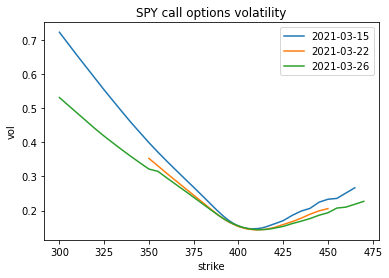

In [113]:
plt.figure(1)
plt.plot(strike1, vol1, label=exp[0].date())
plt.plot(strike2, vol2, label=exp[1].date())
plt.plot(strike3, vol3, label=exp[2].date())
plt.xlabel('strike')
plt.ylabel('vol')
plt.title("SPY call options volatility")
plt.legend()

In [256]:
from mpl_toolkits import mplot3d

info = ['strike', 'bisec_Root']
delta_T = ['strike', 1]
new_df = DATA1[1][0][info]
for df in DATA1[1]:
    delta_T.append(df['delta_t'].iloc[0]*365)
    call_df = df[df.type == 'c']
    new_df = pd.merge(new_df, call_df[info], on='strike', how='outer')
    new_df.columns = delta_T

In [257]:
new_df = new_df.set_index('strike')
new_df = new_df.drop(new_df.columns[0:4], axis=1)
new_df = new_df.dropna()

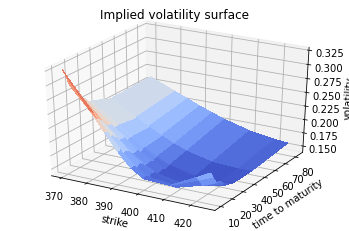

In [279]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
x = new_df.columns
y = new_df.index
X,Y = np.meshgrid(x,y)
Z = new_df
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Y,X,Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title('Implied volatility surface')
ax.set_ylabel('time to maturity')
ax.set_xlabel('strike')
ax.set_zlabel('volatility')
plt.show()

In [50]:
import numpy as np
import matplotlib.pyplot as plt


def f(x):
    if x == 0:
        return 1
    else:
        return np.sin(x) / x


def trapezoidal(f, a, b, N=1000000):
    x = np.linspace(a, b, N + 1)
    g = np.vectorize(f)
    return (b - a) / N * (np.sum(g(x)) - f(a) / 2 - f(b) / 2)


def simpson(f, a, b, N=1000000):
    x = np.linspace(a, b, N + 1)
    g = np.vectorize(f)
    h = (b - a) / N
    return h / 3 * (g(a) + np.sum(g(x[1:-1:2])) * 4
                    + np.sum(g(x[2:-1:2])) * 2 + g(b))

In [51]:
print(trapezoidal(f, -1e6, 1e6, 1000000))
print(simpson(f, -1e6, 1e6, 1000000))

3.1415914506275344
3.141590478023401


In [52]:
def trap_trunc(a=1e5, N=100000):
    return abs(trapezoidal(f, -a, a, N) - np.pi)


def simp_trunc(a=1e5, N=100000):
    return abs(simpson(f, -a, a, N) - np.pi)


def diff(a=1e5, N=100000):
    return trapezoidal(f, -a, a, N) - simpson(f, -a, a, N)

In [53]:
# a is fixed, N increases
N = np.arange(50, 10000, 50)
error_t1 = [trap_trunc(N=i) for i in N]
error_s1 = [simp_trunc(N=i) for i in N]
diff1 = [diff(N=i) for i in N]

# N is fixed, a increases
a = np.arange(50, 10000, 50)
error_t2 = [trap_trunc(a=i) for i in a]
error_s2 = [simp_trunc(a=i) for i in a]
diff2 = [diff(a=i) for i in a]

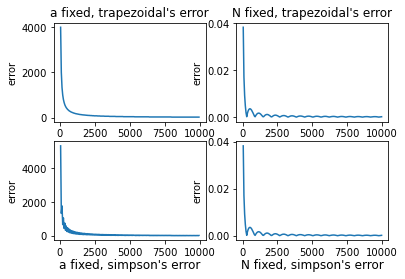

In [60]:
# error plots
t1 = plt.subplot(2, 2, 1)
plt.plot(N,error_t1)
plt.title("a fixed, trapezoidal's error")
plt.ylabel('error')
t2 = plt.subplot(2, 2, 2)
plt.plot(a, error_t2)
plt.title("N fixed, trapezoidal's error")
plt.ylabel('error')

s1 = plt.subplot(2, 2, 3)
plt.plot(N, error_s1)
plt.title("a fixed, simpson's error", y=-0.35)
plt.ylabel('error')
s2 = plt.subplot(2, 2, 4)
plt.plot(N, error_s2)
plt.title("N fixed, simpson's error", y=-0.35)
plt.ylabel('error')
plt.show()

In [62]:
def integral(f, a, b, tol=1e-4, rule=trapezoidal):
    step = 10
    I_k = rule(f, a, b, step)
    I_k1 = rule(f, a, b, step+1)
    while abs(I_k - I_k1) >= tol:
        step += 1
        I_k = I_k1
        I_k1 = rule(f, a, b, step+1)
    return I_k1, step

In [63]:
res1, step1 = integral(f, -1e4, 1e4)
res2, step2 = integral(f, -1e4, 1e4, rule=simpson)

In [64]:
print("The value using trapezoidal is {0}, and take {1} steps".format(res1, step1))
print("The value using simpson is {0}, and take {1} steps".format(res2, step2))

The value using trapezoidal is 3.1339351253458694, and take 3261 steps
The value using simpson is 3.1417268346231753, and take 9398 steps


In [69]:
g = lambda x: 1 + np.exp(-x**2)*np.sin(8*x**(2/3))

res3, step3 = integral(g, 0, 2)
res4, step4 = integral(g, 0, 2, rule=simpson)

In [70]:
print("The value using trapezoidal is {0}, and take {1} steps".format(res3, step3))
print("The value using simpson is {0}, and take {1} steps".format(res4, step4))

The value using trapezoidal is 2.0337775786407293, and take 64 steps
The value using simpson is 2.037422756355833, and take 6682 steps
